In [1]:
import pickle
from pprint import pprint
print = pprint
import tqdm.notebook as tqdm
import glob

from pathlib import Path
from typing import List, Dict, Union, Tuple
import random
from functools import reduce

import torch
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd

import neuralhydrology
from neuralhydrology.datasetzoo.basedataset import BaseDataset
from neuralhydrology.utils.config import Config
from neuralhydrology.evaluation import metrics
from neuralhydrology.nh_run import start_run, eval_run

random.seed(42)

### Setup needed attributes

In [2]:
def df_from_list(df_list: list, merge_col='date') -> pd.DataFrame:
    """Function merge DataFrames from list to the single frame

    Args:
        df_list (list): List of dataframes
        merge_col (str, optional): column on which merge will be perfomed.
                                   Defaults to 'date'.

    Returns:
        pd.DataFrame: Merged dataframe
    """
    return reduce(lambda left, right: pd.merge(left, right, on=merge_col),
                  df_list)


attribute_list = [pd.read_pickle(my_file).reset_index() for my_file
                  in glob.glob('./attributes/*.pkl')]
attribute_list = df_from_list(df_list=attribute_list,
                              merge_col='gauge_id')
attribute_list = attribute_list.set_index('gauge_id', drop=True)
attribute_list.to_csv('./attributes/static_data.csv')


### Prepare AIS GMVO streamflow

In [3]:
# select only valiable data for OpenForecast
ais_stream_OF = pd.read_csv('./streamflow/ais_layers.csv')
ais_stream_OF = ais_stream_OF.dropna(axis=1)
# slice every available observation by it
ais_stream = pd.read_pickle('./streamflow/water_consumption.pkl')
ais_stream = ais_stream.set_index('Date')
ais_stream = ais_stream.dropna(axis=1)
ais_stream.columns = map(str, ais_stream.columns)
ais_stream.index = ais_stream.index.rename('date')
ais_stream = ais_stream[ais_stream_OF.columns]

### Select OpenForecast basins
probably its just AIS GMVO data w/o missing values

In [4]:
gauges = list(ais_stream.columns)
with open('./openf_basins.txt', 'w') as the_file:
    for gauge_name in gauges:
        the_file.write(f'{int(gauge_name)}\n')

### Split test, val, train

In [5]:
random.shuffle(gauges)
gauge_size = len(gauges)

train_gauges = gauges[:int(len(gauges) * 0.8)]
with open('./basins_train.txt', 'w') as the_file:
    for gauge_name in train_gauges:
        the_file.write(f'{gauge_name}\n')

val_gauges = gauges[int(gauge_size * 0.8):int(gauge_size * 0.8) + int(gauge_size * 0.1)]
with open('./basins_val.txt', 'w') as the_file:
    for gauge_name in val_gauges:
        the_file.write(f'{gauge_name}\n')

test_gauges = gauges[int(gauge_size * 0.8) + int(gauge_size * 0.1):]
with open('./basins_test.txt', 'w') as the_file:
    for gauge_name in test_gauges:
        the_file.write(f'{gauge_name}\n')

### Merge meteo and streamflow into single file

In [5]:
meteo_pathes = glob.glob('./forcings/*')


def read_multi_meteo(meteo_pathes: list, gauge_id: str) -> pd.DataFrame:
    meteo_list = [pd.read_pickle(f'{path}/{gauge_id}.pkl')
                  for path in meteo_pathes]
    meteo_list = df_from_list(meteo_list)
    meteo_list = meteo_list.set_index('date')

    meteo_list = meteo_list.rename(columns={'t2m_x': 'temp_max',
                                            't2m_y': 'temp_min',
                                            'msdrswrf': 'srad_avg',
                                            'tp': 'precip'})
    # to celsius
    meteo_list[['temp_min', 'temp_max']] = meteo_list[[
        'temp_min', 'temp_max', ]].apply(lambda x: x-273.15)
    # # to mm
    meteo_list[['precip']] = meteo_list[['precip']] * 1e2

    return meteo_list


In [11]:
path_to_store = Path('./time_series/')
path_to_store.mkdir(exist_ok=True, parents=True)
physio_data = pd.read_pickle('./attributes/physio.pkl')

for gauge in tqdm.tqdm(gauges):
    area = physio_data.loc[gauge, 'ws_area']

    meteo_obs = read_multi_meteo(meteo_pathes,
                                 gauge)
    res_file = pd.DataFrame()
    res_file['QObs'] = 10**3 * \
        (ais_stream[gauge] * 86400) / (area * 10**6)
    res_file.index = pd.to_datetime(res_file.index)
    res_file = res_file.join(meteo_obs)
    res_file = res_file.to_xarray()

    res_file.to_netcdf(f'{path_to_store}/{gauge}.nc')


A Jupyter Widget

### Try to run ...

In [15]:
if torch.cuda.is_available():
    start_run(config_file=Path("./config.yml"))

2023-02-21 17:32:34,126: Logging to runs/era5_whole_wSNW_2102_173234/output.log initialized.
2023-02-21 17:32:34,126: ### Folder structure created at runs/era5_whole_wSNW_2102_173234
2023-02-21 17:32:34,127: ### Run configurations for era5_whole_wSNW
2023-02-21 17:32:34,127: experiment_name: era5_whole_wSNW
2023-02-21 17:32:34,128: run_dir: runs/era5_whole_wSNW_2102_173234
2023-02-21 17:32:34,128: train_basin_file: openf_basins.txt
2023-02-21 17:32:34,128: validation_basin_file: openf_basins.txt
2023-02-21 17:32:34,129: test_basin_file: openf_basins.txt
2023-02-21 17:32:34,129: train_start_date: 2008-01-01 00:00:00
2023-02-21 17:32:34,129: train_end_date: 2015-12-31 00:00:00
2023-02-21 17:32:34,130: validation_start_date: 2016-01-01 00:00:00
2023-02-21 17:32:34,130: validation_end_date: 2017-12-31 00:00:00
2023-02-21 17:32:34,130: test_start_date: 2018-01-01 00:00:00
2023-02-21 17:32:34,131: test_end_date: 2019-12-31 00:00:00
2023-02-21 17:32:34,131: per_basin_train_periods_file: None


/opt/conda/lib/python3.9/site-packages/neuralhydrology/datasetzoo/basedataset.py:421: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1666643016022/work/torch/csrc/utils/tensor_new.cpp:230.)
  per_basin_target_stds = torch.tensor([np.nanstd(obs, axis=1)], dtype=torch.float32)


100%|██████████| 527/527 [00:00<00:00, 1535.87it/s]
2023-02-21 17:32:40,577: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 5266/5266 [04:47<00:00, 18.33it/s, Loss: 0.0000]
2023-02-21 17:37:35,139: Epoch 1 average loss: 0.0019190718485564923
# Epoch 2: 100%|██████████| 5266/5266 [04:46<00:00, 18.37it/s, Loss: 0.0000]
2023-02-21 17:42:21,803: Epoch 2 average loss: 0.00035836096770039974
# Epoch 3: 100%|██████████| 5266/5266 [04:48<00:00, 18.27it/s, Loss: 0.0000]
2023-02-21 17:47:10,002: Epoch 3 average loss: 1.9151045735526213e-05
# Validation: 100%|██████████| 527/527 [00:56<00:00,  9.40it/s]
2023-02-21 17:48:06,146: Stored results at runs/era5_whole_wSNW_2102_173234/validation/model_epoch003/validation_results.p
2023-02-21 17:48:06,158: Epoch 3 average validation loss: 0.00001 -- Median validation metrics: NSE: 0.15761, KGE: 0.14779
# Epoch 4: 100%|██████████| 5266/5266 [04:49<00:00, 18.18it/s, Loss: 0.0000]
2023-02-21 17:52:55,780: Epoch 4 average loss:

### А вот и позор 😳

In [16]:
import matplotlib.pyplot as plt
run_dir = Path("./runs/era5_test54_ealstm_2002_052240")
eval_run(run_dir=run_dir, period="test")


2023-02-20 11:32:53,687: Using the model weights from runs/era5_test54_ealstm_2002_052240/model_epoch042.pt
# Evaluation: 100%|██████████| 54/54 [00:43<00:00,  1.24it/s]
2023-02-20 11:33:37,418: Stored results at runs/era5_test54_ealstm_2002_052240/test/model_epoch042/test_results.p


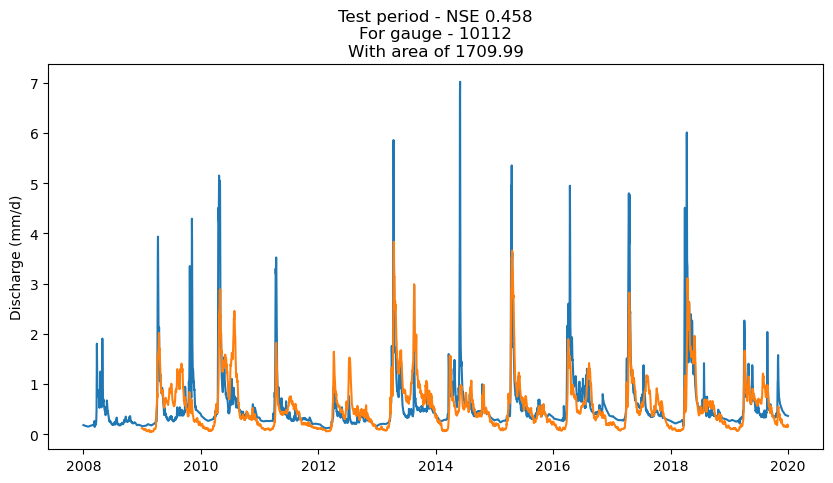

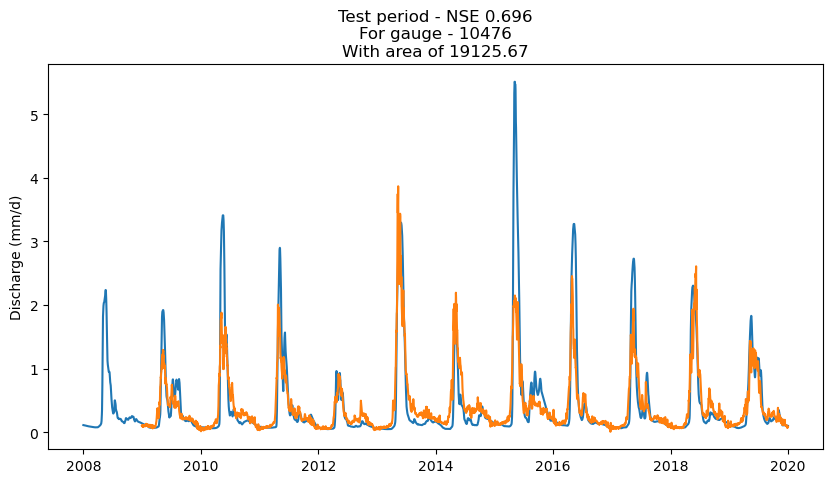

In [10]:
run_dir = Path("./runs/era5_test54_ealstm_2002_052240")

with open(run_dir / "test" / "model_epoch042" / "test_results.p", "rb") as fp:
    results = pickle.load(fp)
counter = 0
for gauge in results.keys():
    if counter == 6:
        break
    qobs = results[gauge]['1D']['xr']['QObs_obs']
    qsim = results[gauge]['1D']['xr']['QObs_sim']

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(qobs['date'], qobs)
    ax.plot(qsim['date'], qsim)
    ax.set_ylabel("Discharge (mm/d)")
    ax.set_title(f"""Test period - NSE {results[gauge]['1D']['NSE']:.3f}
For gauge - {gauge}
With area of {physio_data.loc[gauge]['ws_area']:.2f}""")
    counter += 1

In [6]:
import matplotlib.pyplot as plt
run_dir = Path("./runs/era5_test54_wstatic_1902_182418")
physio_data = pd.read_pickle('./attributes/physio.pkl')

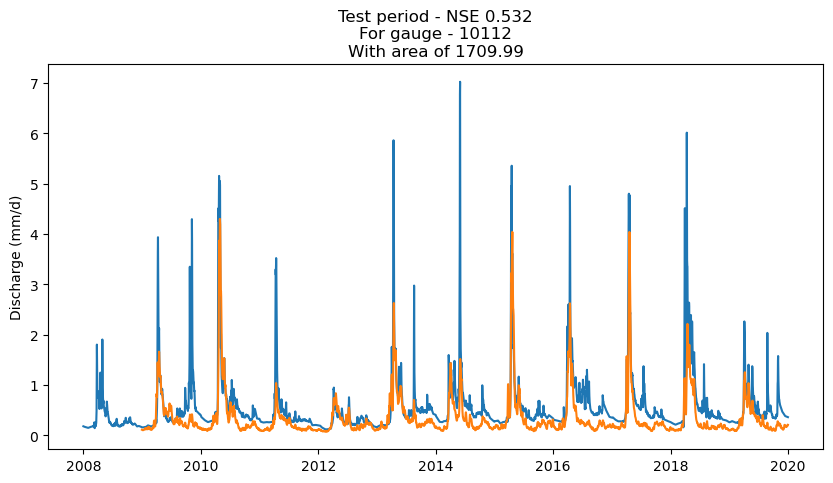

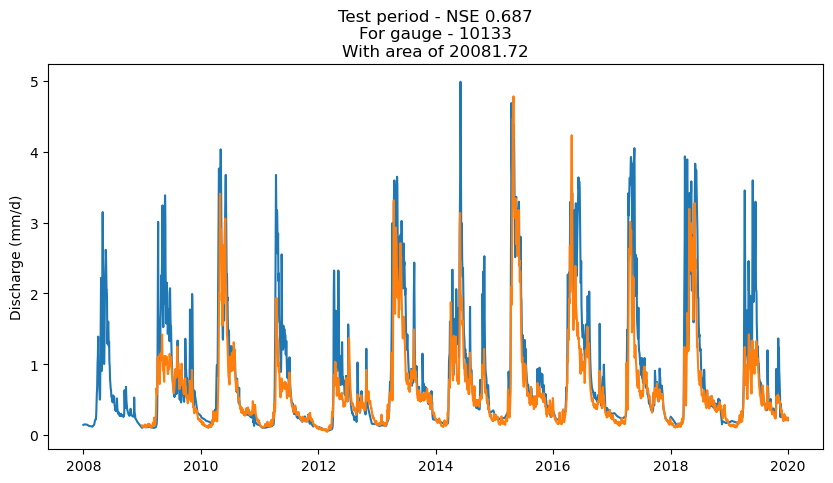

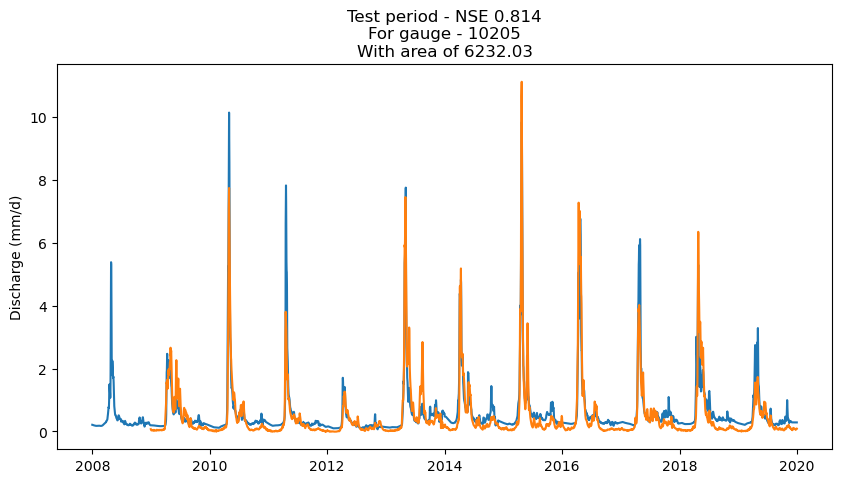

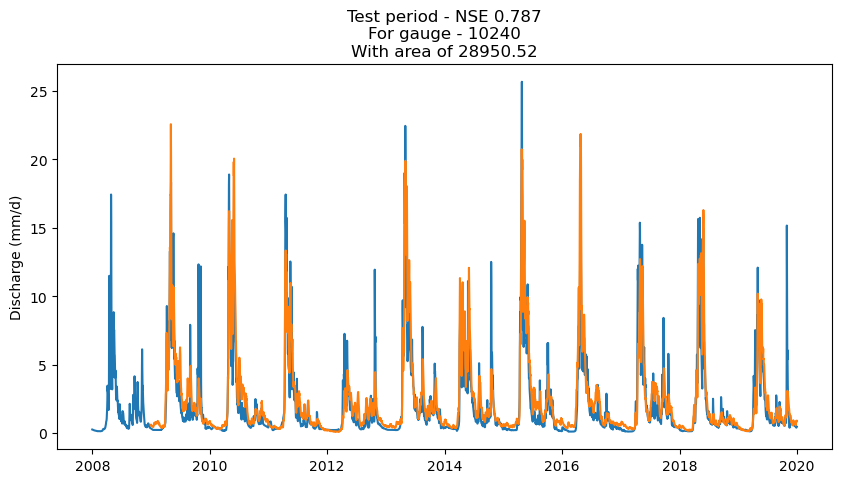

In [7]:
with open(run_dir / "test" / "model_epoch042" / "test_results.p", "rb") as fp:
    results = pickle.load(fp)
counter = 0
for gauge in results.keys():
    if counter == 6:
        break
    qobs = results[gauge]['1D']['xr']['QObs_obs']
    qsim = results[gauge]['1D']['xr']['QObs_sim']

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(qobs['date'], qobs)
    ax.plot(qsim['date'], qsim)
    ax.set_ylabel("Discharge (mm/d)")
    ax.set_title(f"""Test period - NSE {results[gauge]['1D']['NSE']:.3f}
For gauge - {gauge}
With area of {physio_data.loc[gauge]['ws_area']:.2f}""")
    counter += 1



In [21]:
import matplotlib.pyplot as plt
import pickle
from pathlib import Path

run_dir = Path("./runs/everything_LSTM")

with open(run_dir / "test" / "model_epoch030" / "test_results.p", "rb") as fp:
    results = pickle.load(fp)
counter = 0


In [22]:
qobs = results['9337']['1D']['xr']['QObs_obs']
qsim = results['9337']['1D']['xr']['QObs_sim']

fig, ax = plt.subplots(figsize=(16, 10))
ax.plot(qobs['date'], qobs)
ax.plot(qsim['date'], qsim)
ax.set_ylabel("Discharge (mm/d)")
ax.set_title(f"Test period - NSE {results['9337']['1D']['NSE']:.3f}");

In [ ]:

for gauge in results.keys():
    if counter == 6:
        break
    qobs = results[gauge]['1D']['xr']['QObs_obs']
    qsim = results[gauge]['1D']['xr']['QObs_sim']

    fig, ax = plt.subplots(figsize=(16, 10))
    ax.plot(qobs['date'], qobs)
    ax.plot(qsim['date'], qsim)
    ax.set_ylabel("Discharge (mm/d)")
    ax.set_title(f"Test period - NSE {results[gauge]['1D']['NSE']:.3f}")
    counter += 1